# Data Engineering
This notebook steps through a Data Engineering exercise that joins several FHIR resources and converts them at scale into a timeseries-like data model. This notebook should be run after the getting_started notebook. 

First let's import some needed methods and create our Spark session.

In [1]:
from pyspark.sql.functions import col, lit

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

# Create a Spark session that uses local execution, warehouse, and metadata,
# with Hive support to save to tables.
spark = SparkSession.builder \
                    .config('hive.exec.dynamic.partition.mode', 'nonstrict') \
                    .enableHiveSupport() \
                    .getOrCreate()

Now we will make sure the imported data exists:

In [2]:
spark.sql('use tutorial_small')
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,tutorial_small,allergyintolerance,False
1,tutorial_small,careplan,False
2,tutorial_small,claim,False
3,tutorial_small,condition,False
4,tutorial_small,encounter,False
5,tutorial_small,immunization,False
6,tutorial_small,medication,False
7,tutorial_small,medicationrequest,False
8,tutorial_small,observation,False
9,tutorial_small,organization,False


# Valuesets
Common code systems or valuesets, such as those [defined by the VSAC](https://vsac.nlm.nih.gov/valuesets) can be used in the cluster. Here we mostly use user-provided constants to keep the example simple.

In [3]:
from bunsen.stu3.valuesets import push_valuesets, valueset

# Typically these would the isa_loinc or isa_snomed functions, but
# we didn't want the tutorial to require downloading those ontologies.
push_valuesets(spark, 
               {'ldl'               : [('http://loinc.org', '18262-6')],                
                'hdl'               : [('http://loinc.org', '2085-9')],
                'triglycerides'     : [('http://loinc.org', '2571-8')],
                'hba1c'             : [('http://loinc.org', '4548-4')], 
                'chd'               : [('http://snomed.info/sct', '53741008')],
                'hypertension'      : [('http://snomed.info/sct', '38341003')],
                'mi'                : [('http://snomed.info/sct', '22298006')], 
                # The following were loaded in the getting started notebook.
                'diabetes_risks'    : valueset('http://engineering.cerner.com/bunsen/example', '201806001'),                
                'example'           : valueset('http://hl7.org/fhir/ValueSet/example-extensional', '20150622')},
               database='tutorial_ontologies');   

# Projected onto simple tables
As seen in the Getting Started notebook, we can interactively query FHIR datasets and project them onto simple tables. Notice the use of the in_valueset UDF that references the valueset names seen above.

In [4]:
spark.sql("""
select subject.reference,
       code.coding[0].system system, 
       code.coding[0].code code,
       onsetDateTime
from condition
where in_valueset(code, 'chd')
""").limit(10).toPandas()

,reference,system,code,onsetDateTime
0,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,http://snomed.info/sct,53741008,2014-09-14T07:45:47-05:00
1,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,http://snomed.info/sct,53741008,2017-05-22T06:56:19-05:00
2,urn:uuid:7460ce37-9f41-4543-b906-7308e9932d21,http://snomed.info/sct,53741008,1974-08-06T06:50:32-05:00
3,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,http://snomed.info/sct,53741008,2015-08-28T01:17:20-05:00
4,urn:uuid:214ff775-6924-4ecf-aedd-9847146fe66b,http://snomed.info/sct,53741008,2013-01-31T00:59:02-06:00
5,urn:uuid:0dbb75c9-3524-401b-988a-1bb271958e83,http://snomed.info/sct,53741008,2003-01-22T21:39:48-06:00
6,urn:uuid:7f4dc74b-16f4-4a55-a1ad-8a42e050488c,http://snomed.info/sct,53741008,1997-10-01T23:25:01-05:00
7,urn:uuid:98a6cbbb-585f-447e-8a49-2ea746d8225e,http://snomed.info/sct,53741008,2008-10-08T11:30:48-05:00
8,urn:uuid:5c9ab509-de8a-4bdb-90f0-29244b4fb7a5,http://snomed.info/sct,53741008,1999-05-31T01:13:28-05:00
9,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,http://snomed.info/sct,53741008,2009-03-28T12:13:51-05:00


A similar example for the [FHIR Observation Model](https://www.hl7.org/fhir/observation.html). 

In [5]:
ldl_values = spark.sql("""
select subject.reference, 
       code.coding[0].code code,
       valueQuantity.value,
       effectiveDateTime
from observation 
where in_valueset(code, 'ldl') and year(effectiveDateTime) = 2017
""")

ldl_values.limit(10).toPandas()

,reference,code,value,effectiveDateTime
0,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,18262-6,76.1167,2017-05-22T06:56:19-05:00
1,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,18262-6,146.9537,2017-09-01T01:17:20-05:00
2,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,18262-6,70.7331,2017-04-08T12:13:51-05:00
3,urn:uuid:aa2be051-d228-419d-9a60-18b64e10ea81,18262-6,134.6488,2017-03-15T12:52:10-05:00
4,urn:uuid:f20b8e92-5088-4c29-bcb6-34a2953f404e,18262-6,76.0055,2017-08-10T22:44:24-05:00
5,urn:uuid:75d2e5a2-05b8-4192-8021-315683f46f57,18262-6,93.5933,2017-10-08T07:25:26-05:00
6,urn:uuid:6f58dbea-7532-4090-97a8-79982bab98f5,18262-6,94.8853,2017-05-28T14:27:57-05:00
7,urn:uuid:aa251e83-9a9b-446f-ba2f-87e2da7c4d34,18262-6,76.6896,2017-03-06T01:40:30-06:00
8,urn:uuid:e33851db-e468-44cc-85f5-2a322dac7717,18262-6,74.4160,2017-08-09T06:37:22-05:00
9,urn:uuid:a24074d9-8d2f-4a15-9e82-0a633bba7d39,18262-6,131.7946,2017-07-21T14:07:12-05:00


## Data analysis
Now that we have data in a tabular format, we can easily calculate summary statistics or plot its distribution. (Of course, in a real system the counts would be much higher, and the distribution much smoother.)

In [6]:
ldl_values.describe().toPandas()

,summary,reference,code,value,effectiveDateTime
0,count,62,62,62,62
1,mean,None,None,111.52852903,None
2,stddev,None,None,30.612884121507545,None
3,min,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,18262-6,57.6543,2017-01-11T07:33:23-06:00
4,max,urn:uuid:fd8e392e-661c-41de-aae9-b344fc2c1a9f,18262-6,182.9637,2017-12-27T17:29:37-06:00


Text(0.5,0,'value')

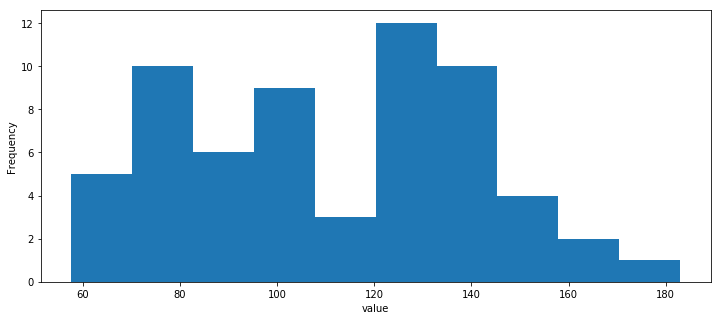

In [7]:
ldl_values.select(col('value').cast('float')) \
          .toPandas() \
          .plot(kind='hist', 
                bins=10, 
                figsize=(12,5), 
                legend=False) \
          .set_xlabel("value")

## Building Cohorts
Let's track down a group of people we want to analyze. In this case, we're interested in people:

* With at least one of the following:
 * A diabetes condition
 * A pre-diabetes condition
 * An elevated HbA1c value 
* And who haven't had a wellnes visit in some time

We can achieve this by simple creating dataframes with the desired subset of people. In this example, we have "diabetes_risks" valueset that contains diabetes-related conditions, so we just query it:

In [8]:
diabetes_conditions = spark.sql("""
select id condition_id, 
       subject.reference person_ref, 
       coding.system,
       coding.code,
       coding.display
from condition 
     lateral view explode(code.coding) nested as coding
where in_valueset(code, 'diabetes_risks')
""")

diabetes_conditions.limit(10).toPandas()

,condition_id,person_ref,system,code,display
0,urn:uuid:9c72cc16-2191-461f-a734-43b2c3e146d3,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,http://snomed.info/sct,44054006,Diabetes
1,urn:uuid:56d5d265-3352-40df-8ad4-ed2ef8c5f348,urn:uuid:214ff775-6924-4ecf-aedd-9847146fe66b,http://snomed.info/sct,15777000,Prediabetes
2,urn:uuid:69de8a40-c511-4635-9c8c-8e5f4377c8cf,urn:uuid:7f4dc74b-16f4-4a55-a1ad-8a42e050488c,http://snomed.info/sct,15777000,Prediabetes
3,urn:uuid:e919cd87-9bc9-4ea9-ab97-342ab94730da,urn:uuid:3769d894-6c38-4d2f-a0a6-f0ff5e098a58,http://snomed.info/sct,44054006,Diabetes
4,urn:uuid:a13c7861-750b-447b-9e06-e7cf009f7a85,urn:uuid:2d5049e5-39e5-4209-8f67-90d512d495c7,http://snomed.info/sct,15777000,Prediabetes
5,urn:uuid:8c652cb2-2262-4215-ae7d-f80b6916a229,urn:uuid:75d2e5a2-05b8-4192-8021-315683f46f57,http://snomed.info/sct,15777000,Prediabetes
6,urn:uuid:42eb38f9-1c13-4688-baf8-5123f741a697,urn:uuid:6f58dbea-7532-4090-97a8-79982bab98f5,http://snomed.info/sct,15777000,Prediabetes
7,urn:uuid:6df0d5b9-b330-4653-a67c-4da2e3713643,urn:uuid:aa251e83-9a9b-446f-ba2f-87e2da7c4d34,http://snomed.info/sct,15777000,Prediabetes
8,urn:uuid:c0574786-0be8-4a19-b986-36bc880094d8,urn:uuid:bb98a0cc-7990-4845-977d-8c17e1811bb1,http://snomed.info/sct,15777000,Prediabetes
9,urn:uuid:5add6b55-e4c0-4f11-92ee-cab7fc3e0099,urn:uuid:1f07abb1-76ec-4af4-9bf5-92b595434384,http://snomed.info/sct,15777000,Prediabetes


Note that we can add further qualifications or explore the entire dataset interactively to make sure our query is producing the expected results.

Now let's find people with a high hba1c:

In [9]:
high_hba1c = spark.sql("""
select id observation_id,
       subject.reference person_ref,
       valueQuantity.value,
       valueQuantity.unit
from observation 
     lateral view explode(code.coding) nested as coding
where in_valueset(code, 'hba1c') and
      valueQuantity.value >= 6.5 and
      status = 'final'
""")

high_hba1c.limit(10).toPandas()

,observation_id,person_ref,value,unit
0,urn:uuid:9af19207-e1b3-4ecc-adb7-b79175ba3066,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,10.5958,%
1,urn:uuid:2ef55eab-33ff-434c-b9c3-189af43d41ac,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,8.5958,%
2,urn:uuid:22a1202d-5f41-49f9-b8cc-3db27e128eaa,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,8.5958,%
3,urn:uuid:5c1fcf57-bb3f-48f8-84be-5c8245810f4d,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.4222,%
4,urn:uuid:a1089c2d-ecf8-4a25-b471-d418e6c57fb3,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.4222,%
5,urn:uuid:6906acaa-f312-4c13-b24d-e4f0f9bdbc63,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.1880,%
6,urn:uuid:795048d1-d0b7-4c01-b59c-3d66ea441967,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.1880,%
7,urn:uuid:864bcc8b-df09-4dda-9220-a2725cbe4eba,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.4590,%
8,urn:uuid:fc51eb62-51b6-4035-a9e7-c930081aaf80,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,9.4590,%
9,urn:uuid:62e7616c-0f18-4b55-bac9-aae5d2e4aab3,urn:uuid:aa2be051-d228-419d-9a60-18b64e10ea81,7.9565,%


Now we can just select the person IDs from both of the above dataframes and union them to get our complete list of people who are at risk:

In [10]:
diabetes_risk = high_hba1c.select('person_ref') \
                          .union(diabetes_conditions.select('person_ref')) \
                          .distinct()
        
diabetes_risk.limit(10).toPandas()

,person_ref
0,urn:uuid:1d6fb98a-1716-4313-a3f9-273b5f89fea3
1,urn:uuid:72d4853d-0c27-4f5c-8274-4e301e593b31
2,urn:uuid:7f4dc74b-16f4-4a55-a1ad-8a42e050488c
3,urn:uuid:17c10896-7229-45af-ba70-6975eb174a43
4,urn:uuid:f79409d8-aefa-4425-a41b-f30057147f37
5,urn:uuid:bb98a0cc-7990-4845-977d-8c17e1811bb1
6,urn:uuid:209de376-91bd-4864-878b-183d54f994d1
7,urn:uuid:5dbece6f-58b5-482f-b62c-7a18ff0749cd
8,urn:uuid:214ff775-6924-4ecf-aedd-9847146fe66b
9,urn:uuid:aa251e83-9a9b-446f-ba2f-87e2da7c4d34


Now let's find all of the wellness visits in the last couple years, which we use to exclude people from our cohort:

In [11]:
wellness_visits = spark.sql("""
select subject.reference person_ref, 
       period.start encounter_start,
       period.end encounter_start
from encounter 
where class.code = 'WELLNESS' and
      period.start > '2016'
""")

wellness_visits.limit(10).toPandas()

,person_ref,encounter_start,encounter_start
0,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2016-08-21T07:45:47-05:00,2016-08-21T07:45:47-05:00
1,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2017-08-27T07:45:47-05:00,2017-08-27T07:45:47-05:00
2,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2016-05-16T06:56:19-05:00,2016-05-16T06:56:19-05:00
3,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2017-05-22T06:56:19-05:00,2017-05-22T06:56:19-05:00
4,urn:uuid:5a288b89-ba8d-48f4-b99a-ca6bdd67c2e6,2017-09-01T01:17:20-05:00,2017-09-01T01:17:20-05:00
5,urn:uuid:214ff775-6924-4ecf-aedd-9847146fe66b,2016-02-04T00:59:02-06:00,2016-02-04T00:59:02-06:00
6,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2016-04-02T12:13:51-05:00,2016-04-02T12:13:51-05:00
7,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2017-04-08T12:13:51-05:00,2017-04-08T12:13:51-05:00
8,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2018-04-14T12:13:51-05:00,2018-04-14T12:13:51-05:00
9,urn:uuid:aa2be051-d228-419d-9a60-18b64e10ea81,2016-03-09T11:52:10-06:00,2016-03-09T11:52:10-06:00


Finally, to exclude people who have had wellness visits, we will do an anti-join between our at-risk group and the visits dataframe we created. The end result is a simple table with the required people!

In [12]:
diabetes_without_wellness = diabetes_risk.join(wellness_visits, 
                                               ['person_ref'], 
                                               'left_anti')

diabetes_without_wellness.limit(10).toPandas()

,person_ref
0,urn:uuid:1d6fb98a-1716-4313-a3f9-273b5f89fea3
1,urn:uuid:72d4853d-0c27-4f5c-8274-4e301e593b31
2,urn:uuid:7f4dc74b-16f4-4a55-a1ad-8a42e050488c
3,urn:uuid:17c10896-7229-45af-ba70-6975eb174a43
4,urn:uuid:bb98a0cc-7990-4845-977d-8c17e1811bb1
5,urn:uuid:cfdd0496-7fcd-49d1-be6c-b63a70b443d3
6,urn:uuid:2d5049e5-39e5-4209-8f67-90d512d495c7
7,urn:uuid:1f07abb1-76ec-4af4-9bf5-92b595434384
8,urn:uuid:939da57c-e485-4063-8fae-e03cb47330a2
9,urn:uuid:3769d894-6c38-4d2f-a0a6-f0ff5e098a58


## Building a Time Series
We've looked at some general queries, but a number of machine learning and other analysis works best if we can create a time series from our data. We'll start with some (arbitrary) observation values by month.

Except for the *in_valueset* method, all of this is standard SQL, leverage Apache Spark's support of nested structures. The "group by" clause defines the time periods to aggregate by, and aggregation functions like *avg* or *max* will conditionally include values that satisfy the nested *if* expression.

Advanced SQL users can also leverage window functions over this data. See the Spark documentation for details.

In [13]:
observations = spark.sql("""
select subject.reference patient_id,
       year(effectiveDateTime) year,
       month(effectiveDateTime) month,
       
       avg(if(in_valueset(code, 'hba1c'), 
              valueQuantity.value, 
              null)) avg_hba1c_level,       

       avg(if(in_valueset(code, 'ldl'), 
              valueQuantity.value, 
              null)) avg_ldl,

       avg(if(in_valueset(code, 'hdl'), 
              valueQuantity.value, 
              null)) avg_hdl,
                                          
       max(if(in_valueset(code, 'triglycerides'), 
              valueQuantity.value, 
              null)) max_triglycerides
              
from observation
where effectiveDateTime >= '2013-01-01' and
      effectiveDateTime < '2018-01-01'
group by subject.reference, 
         year(effectiveDateTime), 
         month(effectiveDateTime)
order by patient_id, year, month 
""").cache()

In [14]:
observations.limit(10).toPandas()

,patient_id,year,month,avg_hba1c_level,avg_ldl,avg_hdl,max_triglycerides
0,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2013,3,6.03680000,None,None,None
1,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2014,3,6.25720000,80.19360000,75.33900000,121.3708
2,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2015,3,6.17500000,None,None,None
3,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2015,11,None,None,None,None
4,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2016,4,6.15090000,None,None,None
5,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,2017,4,6.27880000,70.73310000,64.90330000,123.0671
6,urn:uuid:015da593-16ae-44fb-861d-8b2b891404e2,2013,5,None,None,None,None
7,urn:uuid:015da593-16ae-44fb-861d-8b2b891404e2,2014,11,None,None,None,None
8,urn:uuid:11c02cdc-8ea8-4231-9d05-2b34adc62c83,2013,4,None,None,None,None
9,urn:uuid:11c02cdc-8ea8-4231-9d05-2b34adc62c83,2014,5,None,None,None,None


Here is a similar aggregation for conditions. We can include an arbitrary number of FHIR resources using this pattern.

In [15]:
conditions = spark.sql("""
select subject.reference patient_id,
       year(onsetDateTime) year,
       month(onsetDateTime) month,

       max(if(in_valueset(code, 'hypertension'), 
              true, 
              false)) hypertension,
              
       max(if(in_valueset(code, 'mi'), 
              true, 
              false)) mi,
              
       max(if(in_valueset(code, 'chd'), 
              true, 
              false)) chd             
              
from condition
where onsetDateTime >= '2013-01-01' and
      onsetDateTime < '2018-01-01'
group by subject.reference, 
         year(onsetDateTime), 
         month(onsetDateTime)
order by patient_id, year, month         
""").cache()

Finally, we grab some demographics data about hte patient and join it to the observations and conditions data frames loaded above.

In [16]:
patients = spark.sql("""
select id patient_id, birthDate from patient
""")

In [17]:
joined_patient = patients \
                 .join(observations, 'patient_id', 'left_outer') \
                 .join(conditions, ['patient_id', 'year', 'month'], 'left_outer') \
                 .where(col('year').isNotNull())

That's it! Let's take a look at our handiwork:

In [18]:
joined_patient.limit(10).toPandas()

,patient_id,year,month,birthDate,avg_hba1c_level,avg_ldl,avg_hdl,max_triglycerides,hypertension,mi,chd
0,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2017,8,1943-10-03,None,None,None,None,None,None,None
1,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2016,8,1943-10-03,None,None,None,None,False,False,False
2,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2015,9,1943-10-03,None,None,None,None,None,None,None
3,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2014,9,1943-10-03,None,71.73480000,62.99910000,131.3209,False,False,True
4,urn:uuid:f88c719e-9875-446d-852b-cddb79fe4998,2013,9,1943-10-03,None,None,None,None,None,None,None
5,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2017,5,1947-01-13,None,76.11670000,60.94370000,119.8152,False,False,True
6,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2016,5,1947-01-13,None,None,None,None,None,None,None
7,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2015,5,1947-01-13,None,None,None,None,None,None,None
8,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2014,5,1947-01-13,None,71.63320000,70.57590000,127.3699,None,None,None
9,urn:uuid:d9ac6b14-7ffd-46cf-9d2f-b4b982b4f1dc,2013,7,1947-01-13,None,None,None,None,False,False,False


## Save to a table 
Now we will save the results of our engineering exercise to a table for others to use. This may be handing off our dataset to an analyst or data scientist for a specific use case, or just keeping a copy for ourselves so we don't need to reproduce it in the future.

In [19]:
spark.sql('create database if not exists my_analysis_work')

# Only needed so this notebook can be run repeatedly
spark.sql('drop table if exists my_analysis_work.example_timeseries')

joined_patient.write.saveAsTable('my_analysis_work.example_timeseries')

Now we can query the table we just saved and see the expected results:

In [20]:
spark.sql('select * from my_analysis_work.example_timeseries limit 10').toPandas()

,patient_id,year,month,birthDate,avg_hba1c_level,avg_ldl,avg_hdl,max_triglycerides,hypertension,mi,chd
0,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,2017,11,1957-08-27,4.71910000,120.18090000,58.64480000,160.0553,None,None,None
1,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,2017,12,1957-08-27,4.71910000,139.63350000,42.80810000,163.5286,None,None,None
2,urn:uuid:d177cec5-47ee-4758-bf58-69f5ec3181c2,2013,11,1944-07-24,None,None,None,None,False,False,True
3,urn:uuid:5dbece6f-58b5-482f-b62c-7a18ff0749cd,2017,1,1959-02-15,None,None,None,None,None,None,None
4,urn:uuid:5df6ecb0-f5d7-4d75-b4f4-25c21c9a4c5f,2013,1,1932-08-14,2.10000000,158.86630000,43.97930000,154.6200,None,None,None
5,urn:uuid:5df6ecb0-f5d7-4d75-b4f4-25c21c9a4c5f,2013,2,1932-08-14,2.10000000,132.38610000,55.50350000,150.2437,False,False,False
6,urn:uuid:17cf8465-1a05-4b6e-ac14-9607214c20ef,2017,9,2004-08-06,None,None,None,None,False,False,True
7,urn:uuid:209de376-91bd-4864-878b-183d54f994d1,2013,1,1959-02-27,6.99310000,135.35910000,54.30050000,172.2309,False,False,False
8,urn:uuid:209de376-91bd-4864-878b-183d54f994d1,2014,1,1959-02-27,6.99310000,120.40610000,48.18740000,169.1451,False,False,True
9,urn:uuid:3d923883-d4f9-4237-838d-ff3ec3190950,2017,11,1947-07-14,1.87330000,104.12960000,72.91530000,112.2814,None,None,None


## What's Next?
Such a simple, tabular model suited for our use case is easily consumed for a variety of analysis. Let's take a look at a few:

### Descriptive Statistics
Machine Learning gets all of the attention, but a lot of problems can be solved with descriptive statistics. Fortunately Apache Spark offers a rich package for this. Here's a single line to compute the correlation between LDL and triglycerides in our dataset:

In [21]:
joined_patient.corr('avg_ldl', 'max_triglycerides')

0.8177939987318618

### Windowing Functions
Spark [Windowing Functions](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) can be easily used with this format to simplify making predictions about future state. 

Here we simplly add a column indicating whether the next time slot for a patient has a Coronary Heart Disease diagnosis:

In [22]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func

window = Window.partitionBy('patient_id').orderBy('year', 'month')

predict_chd = joined_patient.withColumn('next_chd', func.lead('chd').over(window))

predict_chd.limit(10).toPandas()

,patient_id,year,month,birthDate,avg_hba1c_level,avg_ldl,avg_hdl,max_triglycerides,hypertension,mi,chd,next_chd
0,urn:uuid:90a7ded5-a5ce-43df-b973-7bc7ce7a3011,2013,4,1974-11-23,None,86.87340000,73.86550000,142.3448,None,None,None,None
1,urn:uuid:90a7ded5-a5ce-43df-b973-7bc7ce7a3011,2015,4,1974-11-23,None,None,None,None,None,None,None,None
2,urn:uuid:90a7ded5-a5ce-43df-b973-7bc7ce7a3011,2017,4,1974-11-23,None,104.09860000,59.92160000,129.4962,None,None,None,None
3,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2013,3,1938-05-18,None,None,None,None,None,None,None,True
4,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2014,4,1938-05-18,None,None,None,None,False,False,True,False
5,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2014,9,1938-05-18,None,None,None,None,False,False,False,None
6,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2015,9,1938-05-18,None,77.24200000,77.94560000,106.8841,None,None,None,None
7,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2016,9,1938-05-18,None,None,None,None,None,None,None,None
8,urn:uuid:72f33006-cb57-4a08-bc4e-cce1f328f1b0,2017,10,1938-05-18,None,None,None,None,None,None,None,None
9,urn:uuid:75c9acfa-a7d4-44aa-aec0-70aa0a7affcd,2013,12,2003-12-10,None,None,None,None,None,None,None,True


## Machine Learning
Finally, these data engineering tasks create a solid foundation for Machine Learning. We don't have time in this tutorial to go into depth here, but [Spark ML](https://spark.apache.org/docs/2.3.0/ml-pipeline.html) has a number of great references and will be very familiar to anyone familiar with Python's scikit-learn library. Users can also save our the tabular dataset and load it into any external ML tool that better fits their needs. 

```python
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Predict CHD based on features extracted from the pipeline
regression = LogisticRegression(featuresCol='features', 
                                labelCol='next_chd',
                                maxIter=10)

# The pipeline contains several stages that extract and normalize features
# from our tabluar dataset
pipeline = Pipeline(stages=[convert_to_numeric, 
                            extract_lab_features,
                            scaled_lab_values,
                            assemble_feature_vector,
                            regression])

```
Now we can train the pipeline with the table we created above:

```python
# Split our table between training and test data
(train, test) = predict_chd.randomSplit([0.7, 0.3])

model = pipeline.fit(train)
```